In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

https://machinelearningmastery.com/training-the-transformer-model/

https://machinelearningmastery.com/training-the-transformer-model/

In [3]:
from keras.optimizers import Adam
from keras.metrics import Mean
from tensorflow import data, train, GradientTape, function

from novel.transformer.components.transformer import TransformerModel
from novel.transformer.components.utils import LRScheduler, loss_fcn, accuracy_fcn, likelihood_fcn
from novel.transformer.components.example_dataset import PrepareDataset

from time import time

In [4]:
# Define the model parameters

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Define the training parameters
epochs = 2
batch_size = 8
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

# Instantiate an Adam optimizer
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the training and test splits of the dataset
dataset = PrepareDataset()
trainX, trainY, train_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset('english-german-both.pkl')
print(f'X Length: {trainX.shape}')

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
train_likelihood = Mean(name='train_likelihood')

# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

predictions = []
targets = []
losses = []

# Speeding up the training process
@function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
        prediction = training_model(encoder_input, decoder_input, training=True)

        loss = loss_fcn(decoder_output, prediction)
        accuracy = accuracy_fcn(decoder_output, prediction)
        likelihood = likelihood_fcn(decoder_output, prediction)

    gradients = tape.gradient(loss, training_model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))

    train_loss(loss)
    train_accuracy(accuracy)
    train_likelihood(likelihood)

    return loss, prediction, decoder_output

train_loss.reset_states()
train_accuracy.reset_states()
train_likelihood.reset_states()

print(f"\nStart of training in {len(train_dataset)} batches")

start_time = time()

for step, (train_batchX, train_batchY) in enumerate(train_dataset):
    encoder_input = train_batchX[:, 1:]
    decoder_input = train_batchY[:, :-1]
    decoder_output = train_batchY[:, 1:]

    loss, prediction, target = train_step(encoder_input, decoder_input, decoder_output)

    losses.append(loss.numpy())
    predictions.append(prediction.numpy())
    targets.append(decoder_output.numpy())

    if step % 25 == 0:
        print(f'Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Likelihood {train_likelihood.result():.4f}')

# Print epoch number and loss value at the end of every epoch
print("Training Loss %.4f, Training Accuracy %.4f, Training Likelihood %.4f" % (train_loss.result(), train_accuracy.result(), train_likelihood.result()))

print("Total time taken: %.2fs" % (time() - start_time))

X Length: (9000, 7)

Start of training in 1125 batches
Step 0 Loss 8.3869 Accuracy 0.0000 Likelihood 0.0003
Step 25 Loss 8.1942 Accuracy 0.0079 Likelihood 0.0003
Step 50 Loss 7.7795 Accuracy 0.1100 Likelihood 0.0021
Step 75 Loss 7.4271 Accuracy 0.1478 Likelihood 0.0101
Step 100 Loss 7.1684 Accuracy 0.1673 Likelihood 0.0172
Step 125 Loss 6.9750 Accuracy 0.1792 Likelihood 0.0225
Step 150 Loss 6.8124 Accuracy 0.1856 Likelihood 0.0265
Step 175 Loss 6.6481 Accuracy 0.1957 Likelihood 0.0334
Step 200 Loss 6.5007 Accuracy 0.2064 Likelihood 0.0430
Step 225 Loss 6.3802 Accuracy 0.2124 Likelihood 0.0515
Step 250 Loss 6.2612 Accuracy 0.2183 Likelihood 0.0598
Step 275 Loss 6.1704 Accuracy 0.2226 Likelihood 0.0664
Step 300 Loss 6.0817 Accuracy 0.2268 Likelihood 0.0725
Step 325 Loss 5.9986 Accuracy 0.2308 Likelihood 0.0779
Step 350 Loss 5.9302 Accuracy 0.2341 Likelihood 0.0832
Step 375 Loss 5.8642 Accuracy 0.2377 Likelihood 0.0877
Step 400 Loss 5.8024 Accuracy 0.2408 Likelihood 0.0921
Step 425 Loss 5

In [5]:
len(predictions)

1125

In [6]:
predictions[0].shape

(8, 11, 3667)

In [7]:
targets[0].shape

(8, 11)

In [8]:
print(losses)

[8.386853, 8.408433, 8.330607, 8.467886, 8.3376255, 8.426292, 8.313892, 8.444349, 8.397841, 8.243264, 8.234764, 8.216454, 8.346942, 8.250495, 8.178409, 8.170705, 8.189959, 8.047456, 8.1574745, 7.986497, 7.942635, 7.891108, 7.955856, 7.9313536, 7.9963264, 7.7969327, 7.8713083, 7.7645683, 7.828739, 7.654444, 7.7475348, 7.468847, 7.6394057, 7.4163513, 7.506292, 7.446424, 7.327521, 7.260644, 7.3875785, 7.4603024, 7.339377, 7.130429, 7.375289, 6.9692636, 7.170085, 6.802136, 7.089662, 7.027472, 7.1715055, 6.962539, 6.886456, 6.872827, 6.8107104, 6.916065, 6.815554, 6.8787613, 6.7671227, 6.60521, 6.9552064, 6.7845073, 6.6108932, 6.732376, 6.8318644, 6.667703, 6.6483335, 6.794532, 6.7534647, 6.670492, 6.717696, 6.6110883, 6.526594, 6.4696636, 6.574209, 6.6708384, 6.4368186, 6.5796165, 6.739115, 6.415209, 6.5310874, 6.5067863, 6.415384, 6.44724, 6.5524545, 6.5269265, 6.4199867, 6.528626, 6.4859085, 6.449672, 6.207062, 6.327388, 6.4122014, 6.2603874, 6.3034105, 6.2787485, 6.1674976, 6.5163903, 6

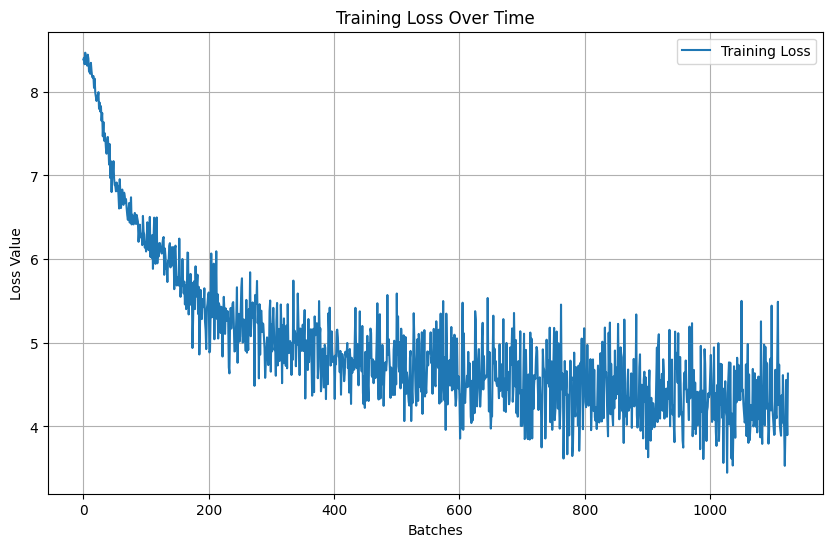

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Batches')
plt.ylabel('Loss Value')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()